# Malleco data
###### Author: Mokhtar Z. Alaya <alayaelm@utc.fr>

In [1]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu

from utils import *
from kernels import Kernel

from scipy.stats import wasserstein_distance

init_notebook_mode(connected=True) ## plotly init

In [2]:
malleco = pd.read_csv('malleco.csv')

In [3]:
malleco.head(), malleco.columns

(   Year Value
 0  1242 1.343
 1  1243 1.044
 2  1244 1.174
 3  1245 1.068
 4  1246 0.913,
 Index(['Year Value'], dtype='object'))

In [4]:
years = []
values = []
for i in range(malleco.shape[0]):
    years.append(malleco['Year Value'][i][:4])
    values.append(malleco['Year Value'][i][5:])
    
df_malleco = pd.DataFrame({'Year': years, 'Value': values})

In [5]:
df_malleco.head()

,Year,Value
0,1242,1.343
1,1243,1.044
2,1244,1.174
3,1245,1.068
4,1246,0.913


In [6]:
df_malleco['Value'] = pd.to_numeric(df_malleco['Value'])
df_malleco['Year'] = pd.to_numeric(df_malleco['Year'])

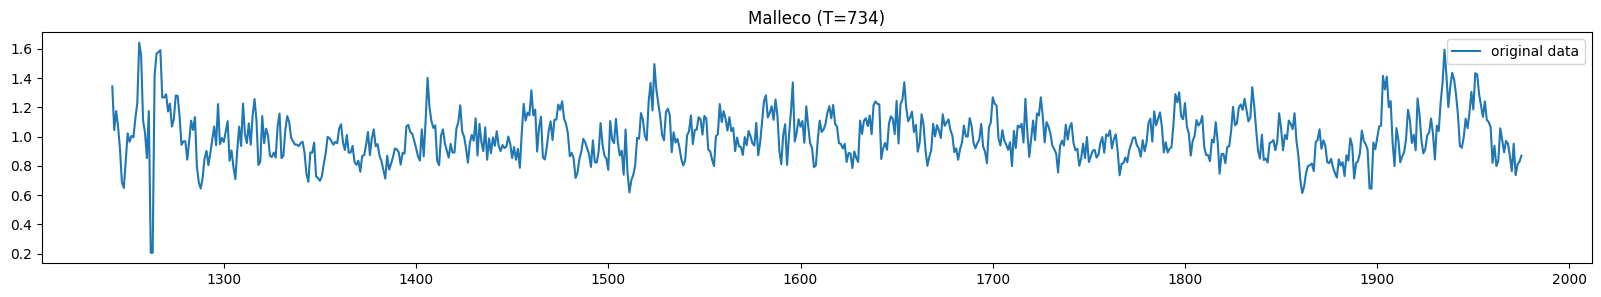

In [7]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(df_malleco['Year'], df_malleco['Value'], label="original data")
#plt.plot(df_malleco['Year'], df_malleco['Value'].diff(), label="diff")
plt.legend()
plt.title("Malleco (T=734)")
plt.show()

In [8]:
df_malleco.shape

(734, 2)

In [9]:
df_malleco['Value'].values.reshape(-1, 1).shape

(734, 1)

In [10]:
np.where(df_malleco['Value'].diff() == np.nan)

(array([], dtype=int64),)

# Nadara-Watson estimator 

In [11]:
C = 50
space_kernel = "gaussian" # "silverman"
time_kernel = "uniform"
T = df_malleco.shape[0]
d = 1
bandwidth = T **(-0.4 / (d+1)) / C
X_dict = df_malleco['Value'].values.reshape(-1,1) #df_malleco['Value'].diff().values.reshape(-1, 1)
X_tvar_2 = df_malleco['Value'].values #df_malleco['Value'].diff().values

GaussUnifKernel = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)
GaussUnifKernel 

weights = {}
for t in range(T):
    weights[str(t)] = GaussUnifKernel.fit(X_dict, t)
    
m_hat = [np.sum(weights[str(t)] * X_tvar_2) for t in range(T)]

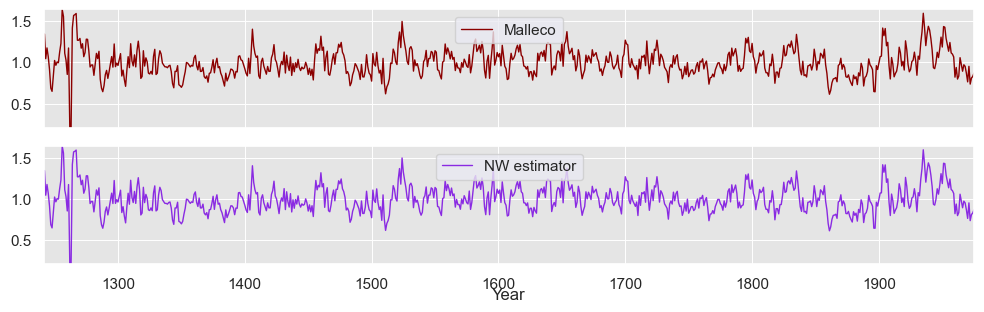

2024/10/23 09:52:28 Saved result in file Malleco-NW-Gaussian-sp-Uniform-time-C-50.pdf


In [14]:
import logging

sns.set(style="darkgrid")

logging.basicConfig(
    format="%(asctime)s %(message)s", datefmt="%Y/%m/%d %H:%M:%S", level=logging.INFO
)

path_fig = "D:/Users/tiniojan/ExperimentsPhD/June_19_24/wasslsp/notebooks/clean-real"

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,3.3) , sharex=True)
plt.subplots_adjust(wspace=0, hspace=0.02)


output_filename = "Malleco-NW-Gaussian-sp-Uniform-time-C-50.pdf"

for axis in ax:
    axis.grid(True, which='major', linestyle='-', linewidth=.7, color='white')  
    #axis.grid(True, which='minor', linestyle=':', linewidth=0.5, color='lightgray')  
    axis.set_facecolor('#E5E5E5')  
    axis.minorticks_on()  

ax[0].plot(df_malleco['Year'].values, X_tvar_2, lw=1, label="Malleco", color="darkred")  # #, color="r") #, cmap=cm)
ax[0].set_xlim(min(df_malleco['Year'].values), max(df_malleco['Year'].values))
ax[0].set_ylim(min(min(m_hat), min(X_tvar_2)),  max(max(m_hat), max(X_tvar_2)))
ax[0].legend(loc='upper center')

ax[1].plot(df_malleco['Year'].values, np.array(m_hat), lw=1, label="NW estimator" , c="blueviolet")#cm_bright[0]) #"orange")
ax[1].set_xlim(min(df_malleco['Year'].values), max(df_malleco['Year'].values))
ax[1].set_ylim(min(min(m_hat), min(X_tvar_2)),  max(max(m_hat), max(X_tvar_2)))
ax[1].legend(loc='upper center')
ax[1].set_xlabel("Year")
ax[1].xaxis.set_label_coords(0.5, -0.19)

plt.savefig(path_fig+output_filename, dpi=300)
plt.tight_layout()
plt.show()
logging.info("Saved result in file %s" % output_filename)

In [13]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

np.sqrt(mse(np.array(m_hat), X_tvar_2)), mae(np.array(m_hat), X_tvar_2)

(np.float64(0.0008914535818807643), np.float64(0.0004835809049098816))